# Slovenia

In [35]:
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import requests

pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina'

## Fetch results

In [89]:
dfs = pd.read_html('http://www.volitve.gov.si/ep2014/udel_vo.html', thousands='.', decimal=',')[3:]

In [90]:
constituencies = []
for i, frame in enumerate(dfs):
    frame_copy = frame.copy()
    frame_copy['constituency_name'] = frame.loc[0, 'Volilni okraj']
    frame_copy['constituency_id'] = str(i + 1)
    frame_copy = frame_copy.iloc[1:]
    frame_copy = frame_copy.reset_index()
    frame_copy = frame_copy.rename(columns={'index': 'district_id'})
    frame_copy.district_id = frame_copy.district_id.astype(str)
    frame_copy['id'] = frame_copy.constituency_id + '0' + frame_copy.district_id.apply(lambda x: x.zfill(2))
    constituencies.append(frame_copy)

In [91]:
df = pd.concat(constituencies)

In [92]:
df.columns = ['district_id', 'district_name', 'eligible', 'voters', 'turnout',
               'turnout 2009', 'turnout 2004', 'constituency_name', 'constituency_id', 'id']

In [93]:
df = df[[x for x in df.columns if '20' not in x]]

In [95]:
df.turnout = df.turnout.str.replace(',', '.').str.replace('\xa0%', '').astype(float)

In [98]:
df.to_csv('../../data/raw/svn.csv', index=False)

In [99]:
df = pd.read_csv('../../data/raw/svn.csv')

## Merge

In [101]:
geo = gpd.read_file('../../data/shapefiles/svn/svn.shp')

In [102]:
geo = geo.to_crs(epsg=4326)

In [105]:
geo = geo.merge(df, left_on='VDV_ID', right_on='id', how='left')

## Export

In [109]:
geo = geo[['district_name', 'turnout', 'geometry']]
geo = geo.rename(columns={'district_name': 'name'})
geo['country'] = 'svn'

In [111]:
geo.to_file('../../data/processed/svn', encoding='utf8')

## Visualize

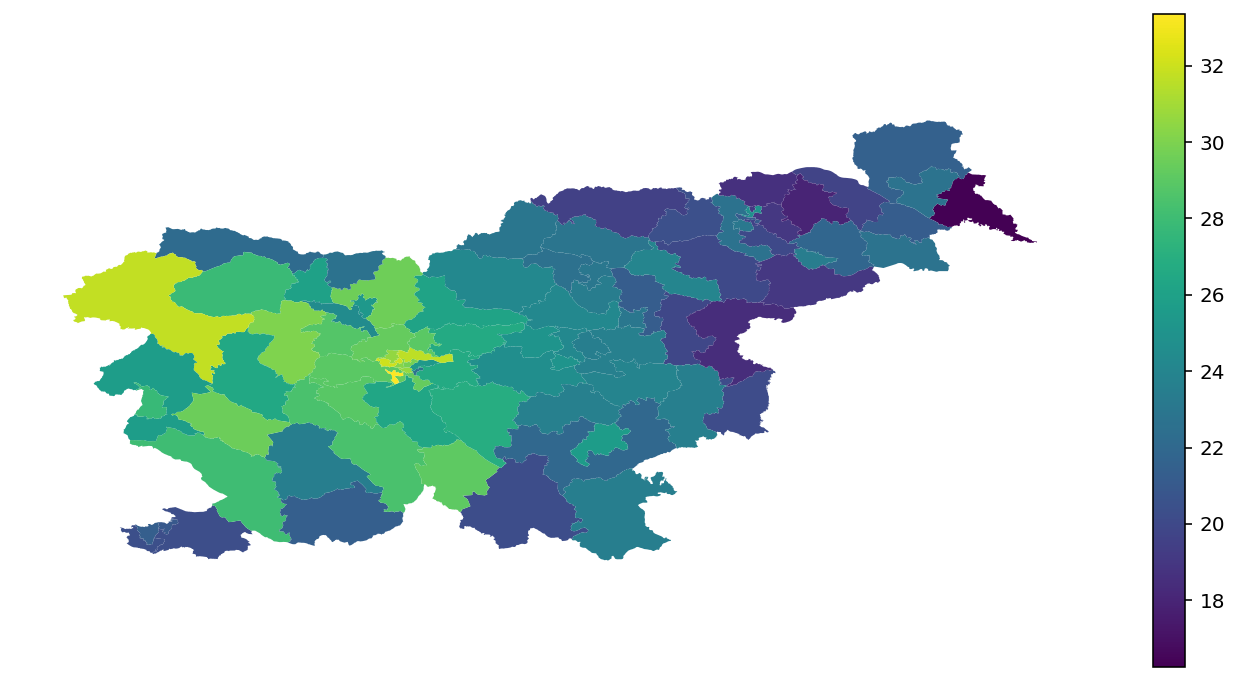

In [113]:
ax = geo.plot(figsize=(12, 6), column='turnout', legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/svn_choropleth.png')